In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
K = 3
MCMC_SIZE = 10
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 300
NUM_HIDDEN = 64
NUM_NSS = 8
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = 0

RECON_SIGMA = torch.ones(1) * 0.1
RADI = torch.ones(1) * 2.0
lg2pi = torch.log(torch.ones(1) * 2 * math.pi)
PATH = 'ag--pcgibbs'

In [5]:
from global_oneshot_mu import *
from local_oneshot_state import *
from local_enc_angle import *
from global_enc_mu import *
from True_decoder import *
# initialization
oneshot_mu = Oneshot_mu(K, D, NUM_HIDDEN, NUM_NSS, CUDA, DEVICE)
oneshot_state = Oneshot_state(K, D, NUM_HIDDEN, CUDA, DEVICE)
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
enc_mu = Enc_mu(D, NUM_HIDDEN, NUM_NSS, CUDA, DEVICE)
dec_x = Dec_x(RADI, RECON_SIGMA, CUDA, DEVICE)
if CUDA:
    with torch.cuda.device(DEVICE):
        oneshot_mu.cuda()
        oneshot_state.cuda()
        enc_angle.cuda()
        enc_mu.cuda()
#         dec_x.cuda()
optimizer =  torch.optim.Adam(list(oneshot_mu.parameters())+list(oneshot_state.parameters())+list(enc_mu.parameters())+list(enc_angle.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

models = (oneshot_mu, oneshot_state, enc_angle, enc_mu, dec_x)

In [6]:
# oneshot_mu.load_state_dict(torch.load('../results/oneshot-mu-' + PATH))
# oneshot_state.load_state_dict(torch.load('../results/oneshot-state-' + PATH))
# enc_angle.load_state_dict(torch.load('../results/enc-angle-' + PATH))
# enc_mu.load_state_dict(torch.load('../results/enc-mu-' + PATH))

In [14]:
LEARNING_RATE = 1e-4
optimizer =  torch.optim.Adam(list(oneshot_mu.parameters())+list(oneshot_state.parameters())+list(enc_mu.parameters())+list(enc_angle.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [15]:
from ag_ep_pcg import *
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    ELBO = 0.0
    EUBO = 0.0
    ESS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        ob = shuffler(ob).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob = ob.cuda()
        eubo, elbo, ess = AG_pcg(models, ob, K, MCMC_SIZE, DEVICE)
        eubo.backward()
        optimizer.step()                     
        ELBO += elbo.detach()
        EUBO += eubo.detach()
        ESS += ess

    flog = open('../results/log-' + PATH, 'a+')
    print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES, time_end - time_start))

epoch=0, eubo=-3752784.7500, elbo=-5204835.0000, ess=2.9856 (64s)
epoch=1, eubo=-3628007.0000, elbo=-5007835.0000, ess=2.9921 (64s)
epoch=2, eubo=-3594654.5000, elbo=-4936586.0000, ess=2.9998 (64s)
epoch=3, eubo=-3534331.5000, elbo=-4910254.0000, ess=2.9961 (64s)
epoch=4, eubo=-3476702.0000, elbo=-4851797.5000, ess=3.0003 (64s)
epoch=5, eubo=-3521680.0000, elbo=-4833712.0000, ess=2.9889 (64s)
epoch=6, eubo=-3498429.2500, elbo=-4862214.5000, ess=3.0030 (65s)
epoch=7, eubo=-3442793.0000, elbo=-4881693.0000, ess=3.0069 (65s)
epoch=8, eubo=-3451092.5000, elbo=-4909768.0000, ess=3.0124 (65s)
epoch=9, eubo=-3440886.5000, elbo=-4950928.0000, ess=3.0098 (65s)
epoch=10, eubo=-3420566.7500, elbo=-4894905.5000, ess=3.0184 (65s)
epoch=11, eubo=-3441701.0000, elbo=-4852727.5000, ess=3.0097 (64s)
epoch=12, eubo=-3448793.2500, elbo=-4873363.5000, ess=3.0050 (64s)
epoch=13, eubo=-3398153.0000, elbo=-4855278.5000, ess=3.0205 (64s)
epoch=14, eubo=-3382667.5000, elbo=-4927789.5000, ess=2.9983 (64s)
epoch

KeyboardInterrupt: 

In [16]:
torch.save(enc_angle.state_dict(), '../results/enc-angle-' + PATH)
torch.save(oneshot_mu.state_dict(), '../results/oneshot-mu-' + PATH)
torch.save(oneshot_state.state_dict(), '../results/oneshot-state-' + PATH)
torch.save(enc_mu.state_dict(), '../results/enc-mu-' + PATH)

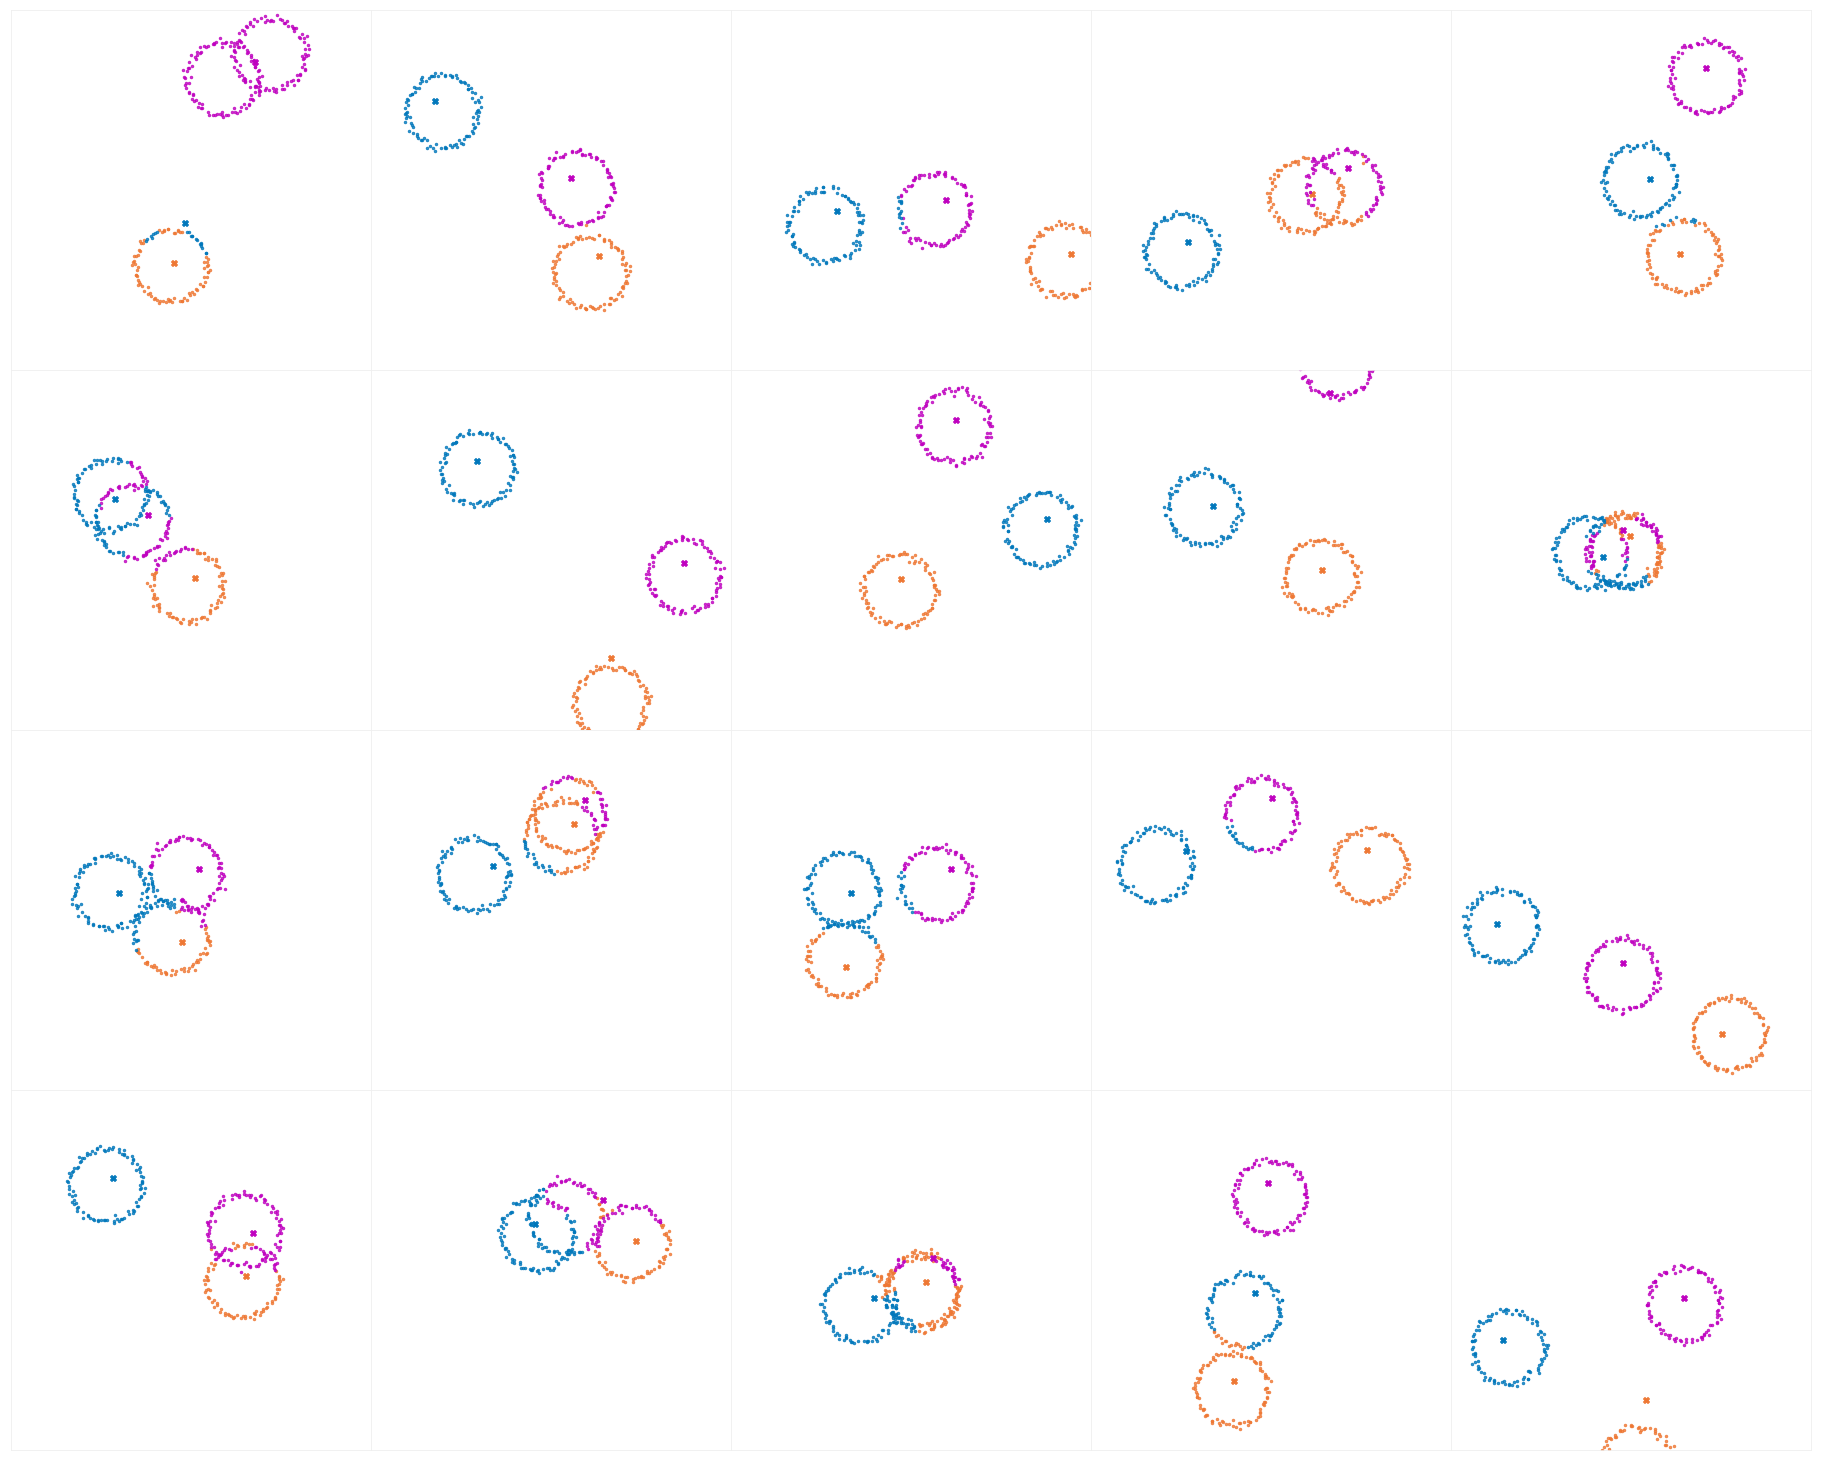

In [17]:
from forward_backward_pcg import *

indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
angle_true = ANGLE[batch_indices]
embed = shuffler(torch.cat((ob, angle_true), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        embed = embed.cuda()
ob = embed[:, :, :, :-1]
angle_true = embed[:, :, :, -1].unsqueeze(-1)
(oneshot_mu, oneshot_state, enc_angle, enc_mu, dec_x) = models
state, angle, mu, w, eubo, elbo, _, _, = oneshot(oneshot_mu, oneshot_state, enc_angle, dec_x, ob, K)
for m in range(MCMC_SIZE):
    if m == 0:
        state = resample(state, w, idw_flag=False) ## resample state
        angle = resample(angle, w, idw_flag=False)
    else:
        state = resample(state, w_state, idw_flag=True)
        angle = resample(angle, w_state, idw_flag=True)
    ## update mu
    mu, angle, w_mu, eubo_mu, elbo_mu, q_mu, p_mu, q_angle, p_angle = Update_mu(enc_mu, enc_angle, dec_x, ob, state, angle, mu)
    mu = resample(mu, w_mu, idw_flag=False)
    angle = resample(angle, w_mu, idw_flag=False)
    ## update z
    state, angle, w_state, eubo_state, elbo_state, q_state, p_state, q_angle, p_angle = Update_state(oneshot_state, enc_angle, dec_x, ob, state, angle, mu)

E_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
E_state = q_state['zs'].dist.probs[0].cpu().data.numpy()
test_ob = ob[0].cpu().data.numpy()

plot_final_samples(test_ob, E_mu, E_state, K, PATH)

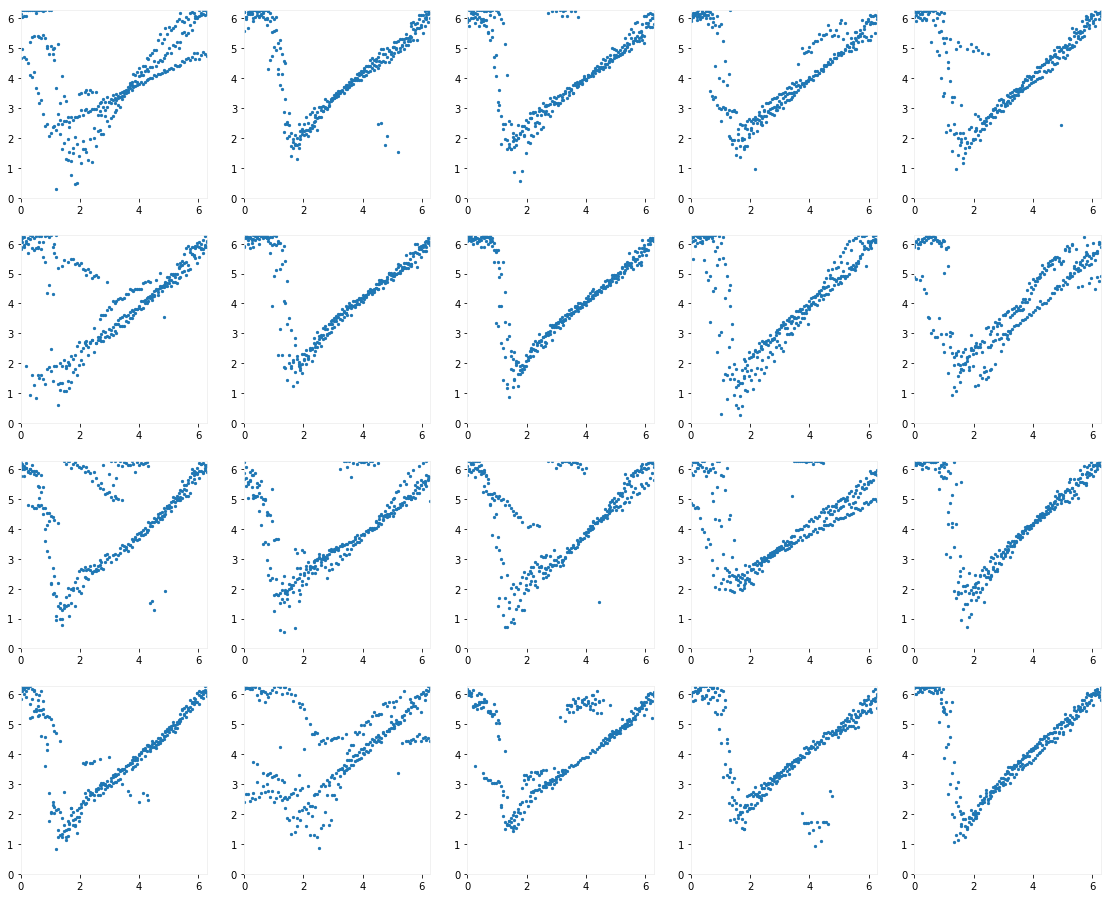

In [18]:
plot_angles(angle, angle_true, 15)

In [19]:
MAX_MCMC_STEPS = 10 ## 12 is maximum mcmc steps
data_ptr = 3
Vis_Interval = 2
page_width = 25
from forward_backward_dec import *

def plot_one_step(ob, state, mu, step, fig, gs, opacity, mu_marker, mu_marker_size, colors, title, data_flag=False):
    B, N, D = ob.shape
    for b in range(B):
        ax = fig.add_subplot(gs[b, step])
        xb = ob[b]
        if data_flag:
            ax.scatter(xb[:, 0], xb[:, 1], c='k', s=3.0, alpha=opacity, zorder=3)
        else:
            K = state.shape[-1]
            zb = state[b]
            mub = mu[b].reshape(K, D)
            assignments = zb.argmax(-1)
            for k in range(K):
                xk = xb[np.where(assignments == k)]
                ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], s=3.0, alpha=opacity, zorder=3)
                ax.scatter(mub[k, 0], mub[k, 1], marker=mu_marker, s= mu_marker_size, c=colors[k])
        ax.set_ylim([-12, 12])
        ax.set_xlim([-12, 12])
        ax.set_xticks([])
        ax.set_yticks([])
        if b == 0:
            ax.set_title(title, fontsize=20)
            
            
def plot_mc(models, Data, K, data_ptr, mcmc_steps, vis_interval, page_width, CUDA, device):
    sample_size = 1
    batch_size = 5
    marker = 'X'
    marker_size = 100
    opacity = 0.8
#     plt.rc('axes',edgecolor='#eeeeee')
    colors = ['#EE7733', 'm', '#0077BB', '#009988']
    gs = gridspec.GridSpec(batch_size, 2+int(mcmc_steps / vis_interval))
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(page_width,page_width*5/7))
    num_datasets = Data.shape[0]
    indices = torch.arange(num_datasets)
    batch_indices = indices[data_ptr*batch_size : (data_ptr+1)*batch_size]
    ob = Data[batch_indices]
    ob = shuffler(ob).repeat(sample_size, 1, 1, 1)
    if CUDA:
        with torch.cuda.device(device):
            ob =ob.cuda()
    test_ob = ob[0].cpu().data.numpy()
    (oneshot_mu, oneshot_state, enc_angle, enc_mu, enc_state, dec_x) = models
    plot_one_step(test_ob, [], [], 0, fig, gs, opacity, marker, marker_size, colors, 'Data', data_flag=True)
    state, angle, mu, w, eubo, elbo, q_mu, q_state = oneshot(oneshot_mu, oneshot_state, enc_angle, dec_x, ob, K)
    E_state = q_state['zs'].dist.probs[0].cpu().data.numpy()
    E_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
    plot_one_step(test_ob, E_state, E_mu, 1, fig, gs, opacity, marker, marker_size, colors, 'One-shot')
    for m in range(mcmc_steps):
        if m == 0:
            state = resample(state, w, idw_flag=False) ## resample state
            angle = resample(angle, w, idw_flag=False)
        else:
            angle = resample(angle, w_angle, idw_flag=True)
        ## update mu
        mu, w_mu, eubo_mu, elbo_mu, q_mu, _  = Update_mu(enc_mu, dec_x, ob, state, angle, mu, K)
        mu = resample(mu, w_mu, idw_flag=True)
        ## update z
        state, w_state, eubo_state, elbo_state, q_state, _ = Update_state(enc_state, dec_x, ob, angle, mu, state)
        state = resample(state, w_state, idw_flag=True)
        ##update angle
        angle, w_angle, eubo_angle, elbo_angle, _, _ = Update_angle(enc_angle, dec_x, ob, state, mu, angle)
        if (m+1) % vis_interval == 0:
            E_state = q_state['zs'].dist.probs[0].cpu().data.numpy()
            E_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
            plot_one_step(test_ob, E_state, E_mu, int((m+1) / vis_interval)+1, fig, gs, opacity, marker, marker_size, colors, 'Step %d' % (m+1))
    plt.savefig('samples.png')
            
plot_mc(models, OB, K, data_ptr, MAX_MCMC_STEPS, Vis_Interval, page_width, CUDA, DEVICE)

ValueError: not enough values to unpack (expected 6, got 5)

<Figure size 1800x1285.71 with 0 Axes>